# Генерация музыкального произведения с помощью НС

## Установка необходимых библиотек


In [ ]:

!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!add-apt-repository -y ppa:mscore-ubuntu/mscore3-stable
!apt-get update
!apt-get install musescore3
!pip install -U music21==9.1.0
!apt-get install xvfb
!pip install numpy tensorflow pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

## Импорт библиотек

In [ ]:
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import music21
from music21 import *
import fluidsynth
import pretty_midi
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import keras.backend as K
from keras.optimizers import Adam

## Загрузка датасета

In [ ]:
# Настройка окружения music21
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore3'
us['directoryScratch'] = '/tmp'

# Загрузка датасета
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
!unzip -qo "classical-music-midi.zip" -d ./dataset

--2025-07-04 07:00:46--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  1.89MB/s    in 1.4s    

2025-07-04 07:00:48 (1.89 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]



In [ ]:
!dir ./dataset

Albeniz    Brahms	Debussy   Liszt        Rachmaninoff  Tchaikovsky
Bach	   Burgmueller	Godowsky  Mendelssohn  Ravel
Balakirev  Chopin	Granados  Moszkowski   Schubert
Beethoven  Christmas	Grieg	  Mozart       Schumann
Borodin    Clementi	Haydn	  Mussorgsky   Sinding


In [ ]:
# Выборка только Шопена для обучения
CLASS_LIST = ["Chopin"]
all_midis_chopin = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath + i
            midi = converter.parse(tr)
            all_midis_chopin.append(midi)

/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEve

In [ ]:
# Выборка Моцарта для начальных последовательностей
MOZART_LIST = ["Mozart"]
all_midis_mozart = []
for compositor in MOZART_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath + i
            midi = converter.parse(tr)
            all_midis_mozart.append(midi)

/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiE

In [ ]:
# Функция извлечения нот
def getNotes(file):
    notes = []
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            notes_to_parse = part.recurse()
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

# Получение корпуса нот Шопена
Corpus = getNotes(all_midis_chopin)
print("Всего нот в корпусе Шопена:", len(Corpus))


Всего нот в корпусе Шопена: 57894


In [ ]:
# Удаление редких нот (менее 100 раз)
count_num = Counter(Corpus)
rare_note = [key for key, value in count_num.items() if value < 100]
for element in Corpus[:]:
    if element in rare_note:
        Corpus.remove(element)
print("Длина корпуса после удаления редких нот:", len(Corpus))

# Создание словаря для мэппинга
symb = sorted(list(set(Corpus)))
L_corpus = len(Corpus)
L_symb = len(symb)
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))
print("Число уникальных символов:", L_symb)

Длина корпуса после удаления редких нот: 53110
Число уникальных символов: 127


In [ ]:

length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Общее количество последовательностей:", L_datapoints)

# Нормализация данных
X = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)
y = tensorflow.keras.utils.to_categorical(targets)

# Получение начальных последовательностей от Моцарта
Corpus_mozart = getNotes(all_midis_mozart)
features_mozart = []
targets_mozart = []
for i in range(0, len(Corpus_mozart) - length, 1):
    feature = Corpus_mozart[i:i + length]
    target = Corpus_mozart[i + length]
    if all(j in mapping for j in feature) and target in mapping:
        features_mozart.append([mapping[j] for j in feature])
        targets_mozart.append(mapping[target])

Общее количество последовательностей: 53070


## Создание модели на основе LTSM

In [ ]:
X_seed = (np.reshape(features_mozart, (len(targets_mozart), length, 1))) / float(L_symb)
y_seed = tensorflow.keras.utils.to_categorical(targets_mozart)

# Разделение данных
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(length, 1)),  # Явный входной слой
    LSTM(256, return_sequences=True),
    Dropout(0.1),
    LSTM(128),
    Dense(128),
    Dropout(0.1),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

## Обучение модели

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=1)

Epoch 1/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.0262 - loss: 4.5583
Epoch 2/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0363 - loss: 4.3827
Epoch 3/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.0395 - loss: 4.3646
Epoch 4/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0407 - loss: 4.3532
Epoch 5/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0424 - loss: 4.3426
Epoch 6/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0395 - loss: 4.3291
Epoch 7/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0420 - loss: 4.3177
Epoch 8/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0418 - loss: 4.3029
Epoch 9/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0471 - loss: 4.2803
Epoch 10/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - acc: 0.0504 - loss: 4.2436
Epoch 11/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0540 - loss: 4.2079
Epoch 12/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0590 - loss: 4.1624
E

## Построение графика потерь

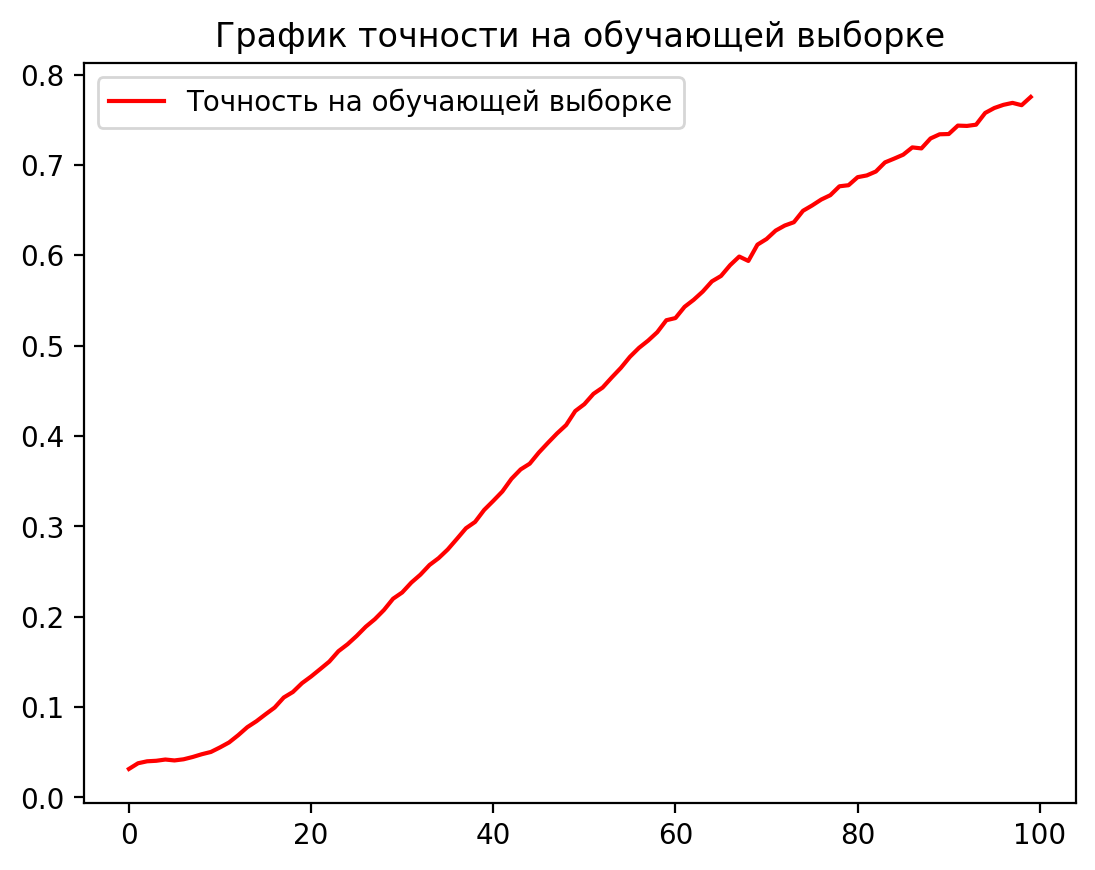

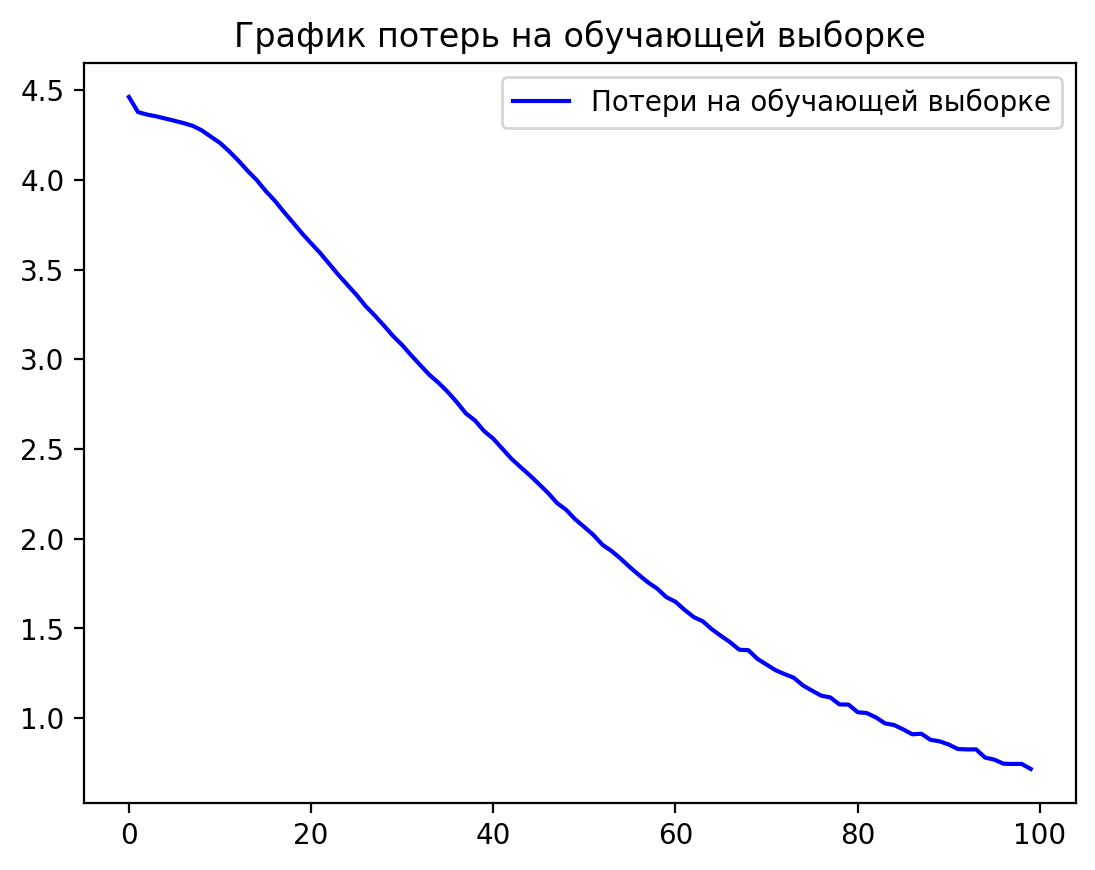

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

In [ ]:
# Функция генерации с параметром температуры
def music_generator(seq_len, temperature=1.0):
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        seed = seed.reshape(1, length, 1)
        prediction = model.predict(seed, verbose=0)[0]

        # Применение температуры
        prediction = np.log(prediction + 1e-10) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # Выбор индекса с учетом вероятностей
        index = np.random.choice(range(len(prediction)), p=prediction)
        index_N = index / float(L_symb)
        notes.append(index)
        music = [reverse_mapping[char] for char in notes]
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)

# Функция преобразования нот в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0
    for i in chunk:
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                chord_chunk = chord.Chord(notes)
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        else:
            note_chunk = note.Note(i)
            note_chunk.offset = offset
            Melody.append(note_chunk)
        offset += 1
    return Melody

## Генерация музыки

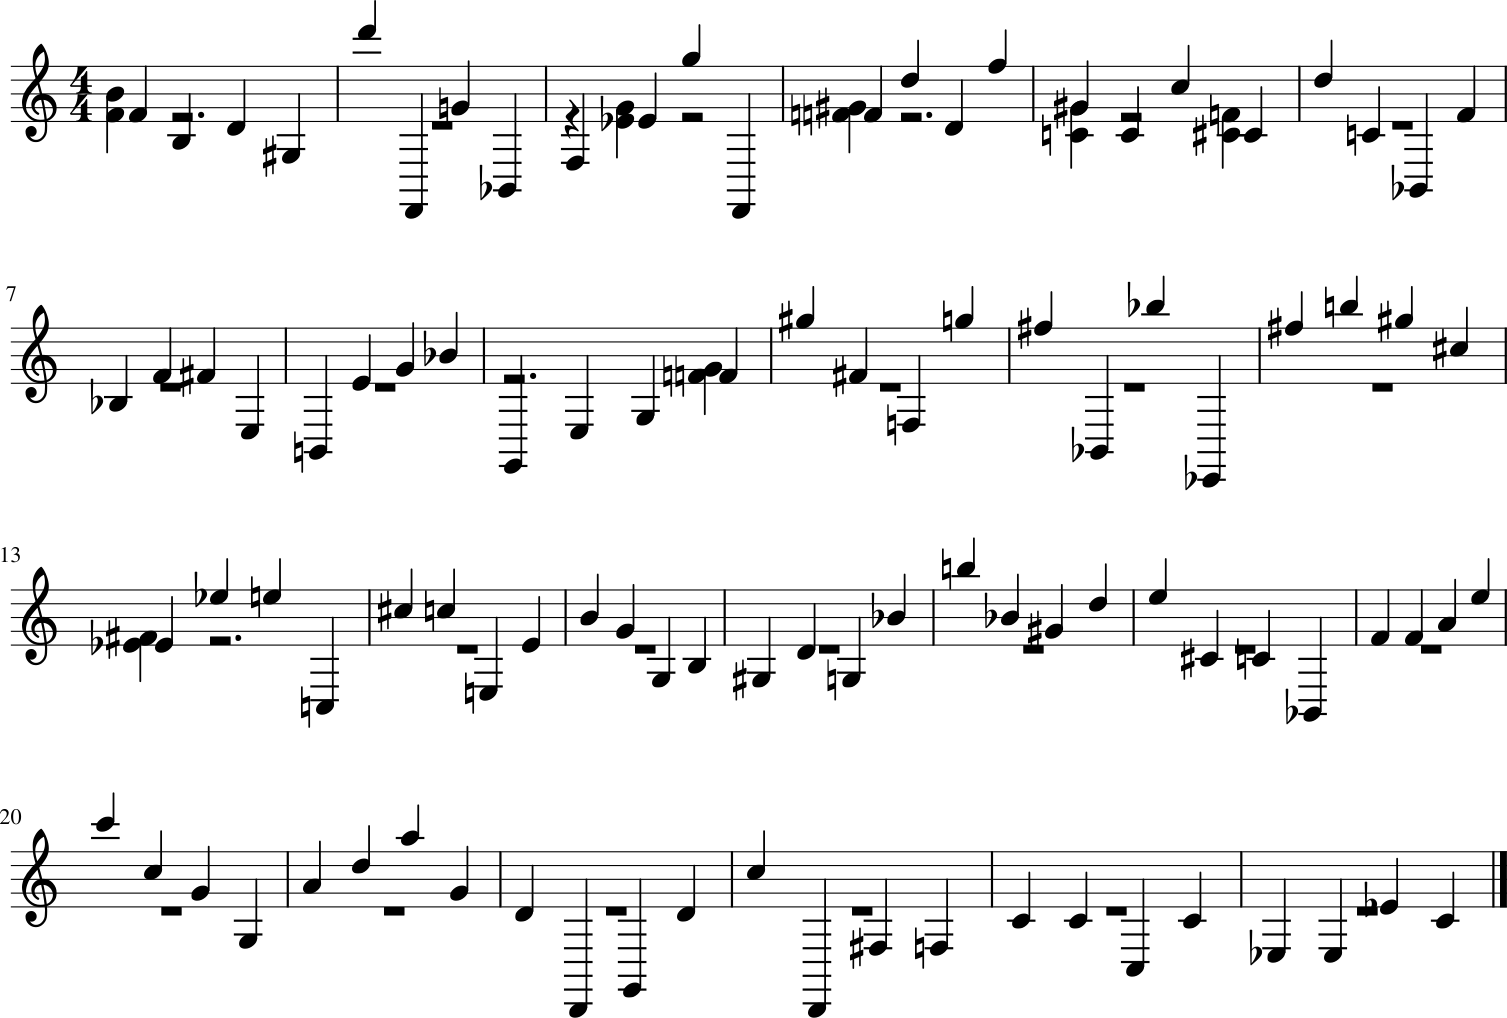

In [ ]:

genMusic = music_generator(100, temperature=1.5)
genMidi = stream.Stream(genMusic)

# Отображение нотного стана
genMidi.show()

# Воспроизведение аудио
genMidi.show('midi')

## Вывод

В рамках данного проекта была обучена LSTM нейронная сеть на произведениях Шопена для генерации музыки в его стиле, используя начальные последовательности Моцарта. Реализована функция генерации с параметром температуры, позволяющим регулировать степень случайности: низкая температура обеспечивает предсказуемость и близость к стилю Шопена, высокая — добавляет творческое разнообразие. Получены ноты и аудиофайл сгенерированного произведения, демонстрирующие возможность модели создавать музыку с учетом заданных параметров.